# Case study: Olist

In this case study we will create an overview on how a generic Data Analysis study on a dataset works.

The case study is divided into several parts:
- Goals
- Parsing
- Preparation (cleaning)
- Processing
- Exploration
- Visualization
- Conclusion

## Goals

In this section we will state the goals we try to obtain by analyzing this dataset. Here are the questions that our customer had:

- Can we predict prices for products?
- Do customers behave predictable, can we recommend specific items to specific customers?
- Sellers with more/better reviews seem to do better, can you quantify this?
- Are there items with a specific time pattern?
- Are products related to geographical information?
- Is there anything else remarkable in our data?

We'll (try to) keep these question in mind when performing the case study.

## Parsing

we start out by importing all necessary libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

in order to download datasets from kaggle, we need an API key to access their API, we'll make that here

In [2]:
if not os.path.exists(os.path.expanduser('~/.kaggle')):
    os.mkdir(os.path.expanduser('~/.kaggle'))

with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    json.dump(
        {
            "username":"lorenzf",
            "key":"7a44a9e99b27e796177d793a3d85b8cf"
        }
        , f)

now we can import kaggle too and download the datasets

In [3]:
import kaggle
kaggle.api.dataset_download_files(dataset='olistbr/brazilian-ecommerce', path='./data', unzip=True)
kaggle.api.dataset_download_files(dataset='olistbr/marketing-funnel-olist', path='./data', unzip=True)

the csv files are now in the './data' folder, we can now read them using pandas, here is the list of all csv files in our folder

In [4]:
os.listdir('./data')

['olist_order_reviews_dataset.csv',
 'olist_order_items_dataset.csv',
 'product_category_name_translation.csv',
 'olist_products_dataset.csv',
 'olist_closed_deals_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_marketing_qualified_leads_dataset.csv',
 'olist_sellers_dataset.csv',
 'olist_customers_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_geolocation_dataset.csv']

we will now parse interesting dataframes.

In [5]:
customers = pd.read_csv('./data/olist_customers_dataset.csv')
print('shape: ' + str(customers.shape))
customers.head()

shape: (99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
sellers = pd.read_csv('./data/olist_sellers_dataset.csv')
print('shape: ' + str(sellers.shape))
sellers.head()

shape: (3095, 4)


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [7]:
products = pd.read_csv('./data/olist_products_dataset.csv')
print('shape: ' + str(products.shape))
products.head()

shape: (32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [8]:
translation = pd.read_csv('./data/product_category_name_translation.csv')
print('shape: ' + str(translation.shape))
translation.head()

shape: (71, 2)


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [9]:
orders = pd.read_csv('./data/olist_order_items_dataset.csv')
print('shape: ' + str(orders.shape))
orders.head()

shape: (112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [10]:
order_reviews = pd.read_csv('./data/olist_order_reviews_dataset.csv')
print('shape: ' + str(order_reviews.shape))
order_reviews.head()

shape: (99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## Preparation

here we perform tasks to prepare the data in a more pleasing format.

### Data Types

Before we do anything with our data, it is good to see if our data types are in order

In [11]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [12]:
customers['customer_city'] = customers['customer_city'].astype('category')
customers['customer_state'] = customers['customer_state'].astype('category')
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   customer_id               99441 non-null  object  
 1   customer_unique_id        99441 non-null  object  
 2   customer_zip_code_prefix  99441 non-null  int64   
 3   customer_city             99441 non-null  category
 4   customer_state            99441 non-null  category
dtypes: category(2), int64(1), object(2)
memory usage: 2.7+ MB


In [13]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [14]:
sellers['seller_city'] = sellers['seller_city'].astype('category')
sellers['seller_state'] = sellers['seller_state'].astype('category')
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   seller_id               3095 non-null   object  
 1   seller_zip_code_prefix  3095 non-null   int64   
 2   seller_city             3095 non-null   category
 3   seller_state            3095 non-null   category
dtypes: category(2), int64(1), object(1)
memory usage: 83.1+ KB


In [15]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [16]:
products['product_category_name'] = products['product_category_name'].astype('category')
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   product_id                  32951 non-null  object  
 1   product_category_name       32341 non-null  category
 2   product_name_lenght         32341 non-null  float64 
 3   product_description_lenght  32341 non-null  float64 
 4   product_photos_qty          32341 non-null  float64 
 5   product_weight_g            32949 non-null  float64 
 6   product_length_cm           32949 non-null  float64 
 7   product_height_cm           32949 non-null  float64 
 8   product_width_cm            32949 non-null  float64 
dtypes: category(1), float64(7), object(1)
memory usage: 2.0+ MB


In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [18]:
orders['shipping_limit_date']= pd.to_datetime(orders['shipping_limit_date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


### Missing values

for each dataframe we apply a few checks in order to see the quality of data

In [19]:
print('customer missing values: ')
print(customers.isna().any())

customer missing values: 
customer_id                 False
customer_unique_id          False
customer_zip_code_prefix    False
customer_city               False
customer_state              False
dtype: bool


In [20]:
print('sellers missing values: ')
print(sellers.isna().any())

sellers missing values: 
seller_id                 False
seller_zip_code_prefix    False
seller_city               False
seller_state              False
dtype: bool


In [21]:
print('products missing values: ')
print(products.isna().any())

products missing values: 
product_id                    False
product_category_name          True
product_name_lenght            True
product_description_lenght     True
product_photos_qty             True
product_weight_g               True
product_length_cm              True
product_height_cm              True
product_width_cm               True
dtype: bool


we can see that there are missing values for products, let's see how many!

In [22]:
products.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

as there are not 'that many' products with missing information, I opted to drop them out. But maybe later i'll come back to that decision if these products seem crucial.

In [23]:
products = products.dropna()

In [24]:
print('orders missing values: ')
print(orders.isna().any())

orders missing values: 
order_id               False
order_item_id          False
product_id             False
seller_id              False
shipping_limit_date    False
price                  False
freight_value          False
dtype: bool


### Duplicates

In [25]:
print('customer duplicates: ')
print(customers.duplicated().any())

customer duplicates: 
False


In [26]:
print('seller duplicates: ')
print(sellers.duplicated().any())

seller duplicates: 
False


In [27]:
print('products duplicates: ')
print(products.duplicated().any())

products duplicates: 
False


In [28]:
print('orders duplicates: ')
print(orders.duplicated().any())

orders duplicates: 
False


No duplicates, that's a good sign, it means that each customer, seller and product is unique!

### Indexing

It is more convenient to work with an index, usually we can use ids as index

In [29]:
customers = customers.set_index('customer_id')
customers.head()

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
customer_id,,,,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [30]:
sellers = sellers.set_index('seller_id')
sellers.head()

,seller_zip_code_prefix,seller_city,seller_state
seller_id,,,
3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [31]:
products = products.set_index('product_id')
products.head()

,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
product_id,,,,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [32]:
orders = orders.set_index('order_id')
orders.head()

,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
order_id,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### Translation
for the products we have a specific dataset that contains the translations, we can apply that to the products dataframe

In [33]:
  translation_dict = translation.set_index('product_category_name')['product_category_name_english'].to_dict()
products['product_category_name'] = products['product_category_name'].cat.rename_categories(translation_dict)
products.head()

,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
product_id,,,,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
3aa071139cb16b67ca9e5dea641aaa2f,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
96bd76ec8810374ed1b65e291975717f,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
cef67bcfe19066a932b7673e239eb23d,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


## Processing

### Product pricing
if we want to find out if there is a correlation between pricing and products, we need to match each product with a price, let's see what happens when we merge orders and products

In [34]:
orders.head()

,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
order_id,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


it seems that we only have prices of complete orders, which makes things more complicated. Below you can see that some orders contain multiple unique products, therefore we cannot easily deduce the price of a single item...

In [35]:
orders.groupby(level=0).apply(lambda x: x.product_id.nunique()).value_counts()

1    95430
2     2846
3      298
4       70
6       10
5        8
7        3
8        1
dtype: int64

well, let us see if we can find all orders with one item, these prices should agree with the price of the product

In [36]:
multi_item_orders = orders[orders['order_item_id']!=1].index.unique().values
single_item_orders = orders.drop(index=multi_item_orders)

In [37]:
products_w_price = products.merge(single_item_orders[['product_id', 'price', 'freight_value']], how='left', left_index=True, right_on='product_id').drop(columns='product_id')

In [38]:
products_w_price

,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
e17e4f88e31525f7deef66779844ddce,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0,10.91,7.39
5236307716393b7114b53ee991f36956,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,248.00,17.99
01f66e58769f84129811d43eefd187fb,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0,79.80,7.82
143d00a4f2dde4e0364ee1821577adb3,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0,112.30,9.54
86cafb8794cb99a9b1b77fc8e48fbbbb,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0,37.90,8.29
...,...,...,...,...,...,...,...,...,...,...
6e4008bddce63615856554f94e5233db,bed_bath_table,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,127.50,11.91
7c8a032bb75e0e4d524b14ba147d4ba5,bed_bath_table,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,127.50,17.14
fc957026f2482ab3bddf91ebc9d0dfc5,bed_bath_table,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,127.00,12.39
NaN,computers_accessories,60.0,156.0,2.0,700.0,31.0,13.0,20.0,NaN,NaN


### grouped per category
It would be interesting to have the averages of each feature grouped per category.

In [39]:
avg_category_product = products_w_price.groupby('product_category_name').mean()
avg_category_product

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
product_category_name,,,,,,,,,
agro_industry_and_commerce,46.189349,910.639053,2.520710,4114.627219,30.739645,25.840237,21.698225,365.199939,28.733963
food,48.781022,1203.888078,1.581509,696.686131,19.260341,13.871046,15.909976,61.121219,14.680448
food_drink,45.186916,1212.219626,1.967290,1202.219626,21.626168,15.813084,16.593458,63.976891,17.074249
art,47.687179,976.379487,1.953846,1538.600000,49.297436,7.897436,36.774359,120.087876,19.120052
arts_and_craftmanship,46.791667,792.208333,3.708333,1369.875000,30.916667,10.916667,21.541667,86.166000,16.152500
...,...,...,...,...,...,...,...,...,...
signaling_and_security,49.641221,796.610687,2.419847,3247.961832,31.229008,25.419847,20.786260,114.344762,22.465238
tablets_printing_image,55.444444,526.305556,1.722222,304.958333,25.680556,9.986111,23.305556,91.165417,15.205278
telephony,52.207986,758.299217,2.939853,255.640384,18.249937,6.242355,13.364417,73.200770,15.705825


### seller reviews
Another thing that says a lot about sales is the seller rating, we combine orders with order reviews for this

In [40]:
seller_review_df = pd.merge(
    orders,
    order_reviews,
    left_index=True,
    right_on='order_id'
).merge(
    sellers, 
    left_on='seller_id', 
    right_index=True
)
seller_review_df.head()

,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,seller_zip_code_prefix,seller_city,seller_state
51963,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,97ca439bc427b48bc1cd7177abe71365,00010242fe8c5a6d1ba2dd792cb16214,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,27277,volta redonda,SP
53184,1,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.9,9.94,1fac9acb29e014e3b9b393d5c8505f99,0188777fe321843a18be24a6e9aa1e53,5,NaN,ÓTIMO,2017-07-29 00:00:00,2017-08-01 20:55:50,27277,volta redonda,SP
81465,1,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.9,20.17,2eab04a8f45efa131d44cf58b37ab595,0191bbb5166d4b9a68df11797d5acfa9,5,NaN,Recebi o patines em perfeitas condições bem an...,2017-08-25 00:00:00,2017-08-28 12:57:25,27277,volta redonda,SP
25922,1,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,2017-10-09 10:35:11,58.9,15.16,9d0e152a1983460f059ddffcb8af03bb,03054d8a8eefc2981cfad06f58e27979,5,NaN,NaN,2017-10-20 00:00:00,2017-10-20 23:45:27,27277,volta redonda,SP
82616,1,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,2017-07-06 15:43:50,139.9,16.74,f4fad24d4bb3462bab004be9a0b753f0,0c325ea6925de749e1420be0cf43587c,4,NaN,"Atendimento excelente,o produto chegou antes d...",2017-07-11 00:00:00,2017-07-13 23:18:14,27277,volta redonda,SP


We can do a lot of things with this, an option is to get the average review per seller

In [41]:
seller_review_df.groupby('seller_id')['review_score'].mean().sort_values()

seller_id
6d04126aba80df143fd038e711b8fd96    1.0
b6c6854d4d92a5f6f46be8869da3fa1a    1.0
34aefe746cd81b7f3b23253ea28bef39    1.0
b7ba853e9551f4558440881fd3e5c815    1.0
17adeba047385fb0c67d8e90b4296d21    1.0
                                   ... 
d7827b2af99326a03b0ed9c7a24db0d3    5.0
4aba6a02a788d3ec81c03137144d9a80    5.0
94ca168e8bcb407ab85c5da308863027    5.0
95cca791657aabeff15a07eb152d7841    5.0
186cdd1b2df32caa72cfb410bba768d3    5.0
Name: review_score, Length: 3090, dtype: float64

or the average review per seller state

In [42]:
seller_review_df.groupby('seller_state')['review_score'].mean().sort_values()

seller_state
AC    1.000000
AM    2.333333
RO    3.857143
PB    3.864865
SE    3.900000
MA    4.002506
SP    4.005078
ES    4.005450
DF    4.033333
PR    4.072292
PI    4.083333
BA    4.090202
SC    4.093865
RJ    4.101670
MG    4.105868
PE    4.132584
CE    4.138298
MT    4.165517
RS    4.214351
GO    4.254826
RN    4.267857
MS    4.469388
PA    4.500000
Name: review_score, dtype: float64

## Exploration

### Product pricing

for the product pricing we created a dataframe that contained the single item price for most products, lets review the dataframe

In [43]:
products_w_price.info()
products_w_price.head()

<class 'pandas.core.frame.DataFrame'>
Index: 90991 entries, e17e4f88e31525f7deef66779844ddce to f3a47ba087f05d39a74ed1b653f0be1b
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   product_category_name       90991 non-null  category
 1   product_name_lenght         90991 non-null  float64 
 2   product_description_lenght  90991 non-null  float64 
 3   product_photos_qty          90991 non-null  float64 
 4   product_weight_g            90991 non-null  float64 
 5   product_length_cm           90991 non-null  float64 
 6   product_height_cm           90991 non-null  float64 
 7   product_width_cm            90991 non-null  float64 
 8   price                       87575 non-null  float64 
 9   freight_value               87575 non-null  float64 
dtypes: category(1), float64(9)
memory usage: 7.0+ MB


,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
e17e4f88e31525f7deef66779844ddce,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0,10.91,7.39
5236307716393b7114b53ee991f36956,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,248.00,17.99
01f66e58769f84129811d43eefd187fb,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0,79.80,7.82
143d00a4f2dde4e0364ee1821577adb3,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0,112.30,9.54
86cafb8794cb99a9b1b77fc8e48fbbbb,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0,37.90,8.29


In [44]:
products_w_price.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
count,90991.000000,90991.000000,90991.000000,90991.000000,90991.000000,90991.000000,90991.000000,87575.000000,87575.000000
mean,48.847600,796.600664,2.267290,2120.521085,30.124529,16.479399,23.054434,130.453913,20.405906
std,10.009026,654.302954,1.757818,3807.197438,16.160075,13.306558,11.778329,197.401912,16.052020
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,0.850000,0.000000
25%,42.000000,352.000000,1.000000,300.000000,18.000000,8.000000,15.000000,44.495000,13.440000
50%,52.000000,610.000000,2.000000,700.000000,25.000000,13.000000,20.000000,79.980000,16.500000
75%,57.000000,1000.000000,3.000000,1825.000000,38.000000,20.000000,30.000000,144.900000,21.400000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,6735.000000,409.680000


#### normal distribution

When we would want to predict the price of an item, it means the the other information of that item should correlate with said price. we can do that for all numerical values with a correlation plot. Before we do that let us use shapiro wilk to test normality 

In [45]:
for name, col in products_w_price.loc[:,(products_w_price.dtypes == float).values].iteritems():
    print(name)
    print(scipy.stats.shapiro(col.dropna()))

product_name_lenght
(0.9154905080795288, 0.0)
product_description_lenght
(0.8121932148933411, 0.0)
product_photos_qty
(0.743693470954895, 0.0)
product_weight_g
(0.5443710088729858, 0.0)
product_length_cm
(0.8115382194519043, 0.0)
product_height_cm
(0.8004813194274902, 0.0)
product_width_cm
(0.8457856774330139, 0.0)
price
(0.4680249094963074, 0.0)
freight_value
(0.5769327282905579, 0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Numerical correlation

hmm it seems that we are dealing with very non normal data, which is usually the case if human behaviour is involved. We should be careful when using linear or parametric methods, so instead of calculating the pearson correlation coefficients, I opt to go for spearman rank correlations

In [46]:
pricing_corr = products_w_price.loc[:,(products_w_price.dtypes == float).values].corr(method='spearman')
pricing_corr

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
product_name_lenght,1.000000,0.082110,0.165681,0.077482,0.055458,-0.042872,0.062193,0.026564,0.033853
product_description_lenght,0.082110,1.000000,0.118462,0.103894,-0.014464,0.127800,-0.063551,0.218892,0.123991
product_photos_qty,0.165681,0.118462,1.000000,0.010332,0.001108,-0.073537,-0.012228,0.026766,0.007767
product_weight_g,0.077482,0.103894,0.010332,1.000000,0.618865,0.536049,0.616737,0.524087,0.460155
product_length_cm,0.055458,-0.014464,0.001108,0.618865,1.000000,0.260230,0.638266,0.260411,0.293482
product_height_cm,-0.042872,0.127800,-0.073537,0.536049,0.260230,1.000000,0.342317,0.356680,0.295279
product_width_cm,0.062193,-0.063551,-0.012228,0.616737,0.638266,0.342317,1.000000,0.274180,0.283687
price,0.026564,0.218892,0.026766,0.524087,0.260411,0.356680,0.274180,1.000000,0.445154
freight_value,0.033853,0.123991,0.007767,0.460155,0.293482,0.295279,0.283687,0.445154,1.000000


#### Variance inflation

it looks like there seem to be some interesting correlations, the price is (slightly) correlated with things as product description, weight, length, height, width and freight value, indicating that bigger items are priced higher.
We have to take into account that freight value is on itself correlating with the latter and therefore might be inflating our results, lets use VIF to check this

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [48]:
cols_to_keep = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'freight_value']
vif_compatible_price = products_w_price[cols_to_keep]
vif_compatible_price = vif_compatible_price.dropna(axis='index')
vif_compatible_price = vif_compatible_price.values
vif_price = {}
for idx, col in enumerate(cols_to_keep):
    vif_price[col] = variance_inflation_factor(vif_compatible_price, idx)
    print(col + ": \t" + str(variance_inflation_factor(vif_compatible_price, idx)))

product_name_lenght: 	9.31669476790696
product_description_lenght: 	2.56022139812164
product_photos_qty: 	2.7618344464628604
product_weight_g: 	3.041859125336769
product_length_cm: 	6.820907759918533
product_height_cm: 	3.686708040653942
product_width_cm: 	7.7388710828170835
freight_value: 	4.1851224676888155


As mentioned earlier, the values here are hard to interpret, however the values seem to be lower than my experience expected. If infinite values arise we know that we need to do things different. Let's assume the collinearity between these columns is ok and they don't interfere with eachother enough to make a difference in the outcome.

#### Categorical correlation

Something interesting we haven't looked into yet is the product category, we could try an ANOVA, but knowing at least one category is different is just a beginning.

In [49]:
str(list(products_w_price.dtypes[(products_w_price.dtypes == float)].index))

"['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'price', 'freight_value']"

In [50]:
products_w_price_p_category = [products_w_price.loc[products_w_price['product_category_name']==category,(products_w_price.dtypes == float).values].dropna() for category in products_w_price['product_category_name'].unique()]
result = scipy.stats.f_oneway(*products_w_price_p_category)

anova_price = {}
for name, test, p in zip(list(products_w_price.dtypes[(products_w_price.dtypes == float)].index), result[0], result[1]):
    anova_price[name] = [test, p]

anova_price = pd.DataFrame.from_dict(anova_price, columns=['test', 'p'], orient='index')
anova_price

,test,p
product_name_lenght,75.721841,0.0
product_description_lenght,188.961232,0.0
product_photos_qty,119.219872,0.0
product_weight_g,296.729258,0.0
product_length_cm,387.834682,0.0
product_height_cm,394.784176,0.0
product_width_cm,450.042245,0.0
price,155.185233,0.0
freight_value,98.666293,0.0


it seems that every continuous column has at least one category that differs from the rest, aside from order item id, which is always 1.

#### Grouping by category

Now comes the tricky part, we would like to know if specific categories perform better on the correlations, but this is impossible to do by hand! However python gives us the opportunity to automate this. To do this properly we have to set a rule:
- correlations should be better than the original one without separation of categories

Look closely how we do almost exactly the same, however we aggregate (groupby) based on the category name

In [51]:
pricing_corr

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
product_name_lenght,1.000000,0.082110,0.165681,0.077482,0.055458,-0.042872,0.062193,0.026564,0.033853
product_description_lenght,0.082110,1.000000,0.118462,0.103894,-0.014464,0.127800,-0.063551,0.218892,0.123991
product_photos_qty,0.165681,0.118462,1.000000,0.010332,0.001108,-0.073537,-0.012228,0.026766,0.007767
product_weight_g,0.077482,0.103894,0.010332,1.000000,0.618865,0.536049,0.616737,0.524087,0.460155
product_length_cm,0.055458,-0.014464,0.001108,0.618865,1.000000,0.260230,0.638266,0.260411,0.293482
product_height_cm,-0.042872,0.127800,-0.073537,0.536049,0.260230,1.000000,0.342317,0.356680,0.295279
product_width_cm,0.062193,-0.063551,-0.012228,0.616737,0.638266,0.342317,1.000000,0.274180,0.283687
price,0.026564,0.218892,0.026766,0.524087,0.260411,0.356680,0.274180,1.000000,0.445154
freight_value,0.033853,0.123991,0.007767,0.460155,0.293482,0.295279,0.283687,0.445154,1.000000


In [52]:
pricing_rel_corr = products_w_price.groupby('product_category_name').apply(
    lambda x: x.loc[:,(x.dtypes == float).values].corr(method='spearman') - pricing_corr
    )
pricing_rel_corr

product_name_lenght  ...  freight_value
product_category_name                                                       ...               
agro_industry_and_commerce product_name_lenght                    0.000000  ...       0.036661
                           product_description_lenght             0.542952  ...       0.057213
                           product_photos_qty                     0.187918  ...      -0.009524
                           product_weight_g                       0.177061  ...       0.171163
                           product_length_cm                     -0.053490  ...       0.308595
...                                                                    ...  ...            ...
housewares                 product_length_cm                      0.018919  ...       0.121902
                           product_height_cm                      0.022937  ...      -0.016564
                           product_width_cm                       0.031462  ...       0.085940
                           price                                  0.069826  ...       0.098247
                           freight_value                          0.068276  ...       0.000000

[657 rows x 9 columns]

for those who are already proficient with python can read that I opted to take the absolute correlation (meaning negatives become positives), this way both negative and positive correlations mean the same thing. Then I subtracted with the overall absolute correlation and divided that whole with the overall correlation giving me a relative change. When this relative change is positive, that category has an increased correlation

In [53]:
pricing_corr_stacked = pricing_rel_corr.stack()
pricing_corr_stacked.sort_values(ascending=False)

product_category_name                                                                    
security_and_services              product_width_cm            product_description_lenght    1.063551
                                   product_description_lenght  product_width_cm              1.063551
                                   product_height_cm           product_name_lenght           1.042872
                                   product_name_lenght         product_height_cm             1.042872
pc_gamer                           product_name_lenght         product_height_cm             1.042872
                                                                                               ...   
                                   product_weight_g            product_width_cm             -1.536737
furniture_mattress_and_upholstery  product_length_cm           product_weight_g             -1.542839
                                   product_weight_g            product_length_cm            -1

wow! we seem to be having very strong correlation increases up to 99%!? Is this possible? We should be very suspicious about these results, lets us find out why there are this high increases by calculating the initial correlation of 'security_and_services'

In [54]:
pricing_p_cat_corr = products_w_price.groupby('product_category_name').apply(
    lambda x: x.loc[:,(x.dtypes == float).values].corr(method='spearman')
    )

In [55]:
pricing_p_cat_corr.loc[('security_and_services','price')]

product_name_lenght           1.0
product_description_lenght    1.0
product_photos_qty           -1.0
product_weight_g              1.0
product_length_cm             1.0
product_height_cm             1.0
product_width_cm              1.0
price                         1.0
freight_value                 1.0
Name: (security_and_services, price), dtype: float64

In [56]:
pricing_corr.loc['price']

product_name_lenght           0.026564
product_description_lenght    0.218892
product_photos_qty            0.026766
product_weight_g              0.524087
product_length_cm             0.260411
product_height_cm             0.356680
product_width_cm              0.274180
price                         1.000000
freight_value                 0.445154
Name: price, dtype: float64

This is not normal, a perfect correlation might indicate a category with only one record, let us print the subset of data belonging to this category

In [57]:
products_w_price[products_w_price['product_category_name']=='security_and_services']

,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
bede3503afed051733eeb4a84d1adcc5,security_and_services,48.0,461.0,4.0,400.0,26.0,22.0,11.0,100.00,15.45
2c4ada2e75c2ad41dd93cebb5df5f023,security_and_services,55.0,506.0,1.0,1225.0,27.0,35.0,15.0,183.29,25.77


#### Dealing with small subsets in data

as expected, we only have 2 item here making things a lot more complicated. We can solve this by making a compromise, since predicting prices for categories (of there is a difference in categories) with little to no examples is inaccurate, we can choose to drop all small categories. This means that our prediction is not capable for certain items however.

In [58]:
category_sizes = products_w_price.groupby('product_category_name').size().sort_values()
small_categories = list(category_sizes[category_sizes<50].index.values)
small_categories

['security_and_services',
 'fashion_childrens_clothes',
 'pc_gamer',
 'cds_dvds_musicals',
 'la_cuisine',
 'portateis_cozinha_e_preparadores_de_alimentos',
 'home_comfort_2',
 'flowers',
 'arts_and_craftmanship',
 'diapers_and_hygiene',
 'fashion_sport',
 'party_supplies',
 'music',
 'fashio_female_clothing',
 'furniture_mattress_and_upholstery']

We opted for a minimum of 50 items per category, let's see how that improves our relative correlations:

In [59]:
pricing_corr_stacked.drop(index=small_categories).sort_values(ascending=False)

product_category_name                                                          
fashion_underwear_beach  product_photos_qty          product_height_cm             0.849303
                         product_height_cm           product_photos_qty            0.849303
christmas_supplies       product_width_cm            product_description_lenght    0.838264
                         product_description_lenght  product_width_cm              0.838264
                         product_length_cm           product_description_lenght    0.789431
                                                                                     ...   
fashion_underwear_beach  product_weight_g            product_length_cm            -1.037104
books_imported           price                       product_width_cm             -1.136276
                         product_width_cm            price                        -1.136276
fashion_shoes            product_length_cm           product_width_cm             -1.273546


Now we filtered out smaller categories that might have high fluctuations, however we are not interested into correlations between any 2 columns (keep your goals in mind!) so we are going to filter only the price. I even found a method (xs) which I never use myself, google is your friend!

In [60]:
pricing_corr_stacked.drop(index=small_categories).xs('price', level=1, drop_level=False).sort_values(ascending=False)

product_category_name                                                   
small_appliances_home_oven_and_coffee  price  product_photos_qty            0.705878
computers                              price  product_photos_qty            0.703822
furniture_bedroom                      price  product_photos_qty            0.638002
home_confort                           price  product_name_lenght           0.631313
fashion_shoes                          price  product_name_lenght           0.604471
                                                                              ...   
computers                              price  product_height_cm            -0.810059
construction_tools_lights              price  product_description_lenght   -0.812678
computers                              price  product_length_cm            -0.819188
                                              product_weight_g             -0.984040
books_imported                         price  product_width_cm             -1

Ok, here I personally believe we have something we can work with! We can clearly see a relative change for correlation with certain columns. One thing that still remains is to filter per category the most important change compared to the average correlation

In [61]:
pricing_most_important = pricing_corr_stacked.drop(index=small_categories).xs('price', level=1, drop_level=True).sort_values(ascending=False).reset_index().drop_duplicates(subset=['product_category_name']).set_index('product_category_name')
pricing_most_important.columns = ['parameter', 'relative_correlation']
pricing_most_important.head(10)

,parameter,relative_correlation
product_category_name,,
small_appliances_home_oven_and_coffee,product_photos_qty,0.705878
computers,product_photos_qty,0.703822
furniture_bedroom,product_photos_qty,0.638002
home_confort,product_name_lenght,0.631313
fashion_shoes,product_name_lenght,0.604471
fashion_underwear_beach,product_photos_qty,0.577173
cine_photo,product_description_lenght,0.554634
electronics,product_photos_qty,0.547695
fixed_telephony,product_description_lenght,0.524150


In [62]:
pricing_least_important = pricing_corr_stacked.drop(index=small_categories).xs('price', level=1, drop_level=True).sort_values(ascending=False).reset_index().drop_duplicates(subset=['product_category_name'], keep='last').set_index('product_category_name')
pricing_least_important.columns = ['parameter', 'relative_correlation']
pricing_least_important.tail(10)

,parameter,relative_correlation
product_category_name,,
home_confort,product_length_cm,-0.444956
furniture_bedroom,product_name_lenght,-0.472171
fashion_shoes,product_photos_qty,-0.491136
furniture_living_room,product_description_lenght,-0.507893
audio,product_name_lenght,-0.530846
industry_commerce_and_business,product_height_cm,-0.596886
fashion_underwear_beach,product_length_cm,-0.629531
construction_tools_lights,product_description_lenght,-0.812678
computers,product_weight_g,-0.984040


What we can distill here:
- the quantity of photo's is important for small applicances, computers, furniture,... which is to be expected because you are willing to pay more if you are sure it looks like you want it to look
- the weight of fasion accessories and 'industry commerce' is not as important compared to other categories, as these things are always light, expensive or not

Anyway, now it is up to you to further interpret these values, but I think this should already give a nice idea on how we can estimate prices and how this changes per category.

## Visualization

### Product pricing

Now that we done the exploration, we can back our hypothesi up with some visual representations, many plots you will make will not end up in the final product but are meant to give you a more clear view on the situation itself

#### Normal distribution

In the exploration we talked about the non normal distribution of our dataset, let us plot the numerical columns into histograms to verify this. Fortunately, pandas has a built-in hist method that works perfect.

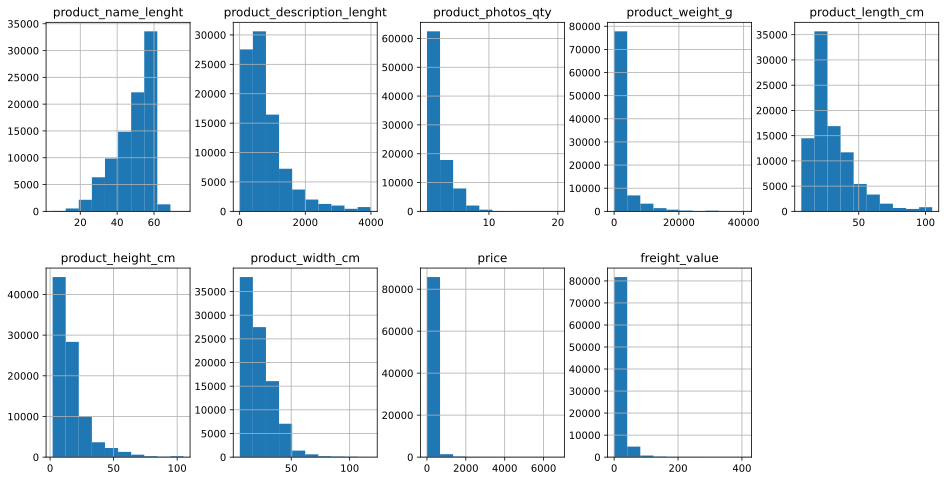

In [63]:
products_w_price.hist(figsize=(16,8), layout=(2,5));

ouch! this doesn't look normally distributed at all, we can also put it into a boxplot and compare with a bar plot

In [64]:
ax = sns.boxplot(data=products_w_price.loc[:,(products_w_price.dtypes == float).values].stack().reset_index(), x='level_1', y=0)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(),rotation=-20,horizontalalignment='left');

Output hidden; open in https://colab.research.google.com to view.

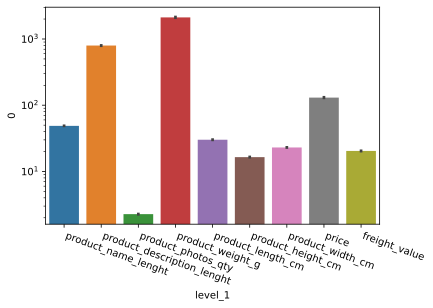

In [65]:
ax = sns.barplot(data=products_w_price.loc[:,(products_w_price.dtypes == float).values].stack().reset_index(), x='level_1', y=0)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(),rotation=-20,horizontalalignment='left');

These 2 plots look alike, but in my opinion the first clearly shows that the peak consists out of outliers, hence the non normal distribution. Can you find the column responsible for this peak using the histograms?

#### Numerical correlation

We saw there were some numerical correlations within the dataset, let us try to visualize these, the first thing that pops into my mind is the pairplot.

In [66]:
#sns.pairplot(data=products_w_price.loc[:,(products_w_price.dtypes == float).values].dropna())

hmm it seems that in this case the pairplot doesn't seem to be that conclusive, but we already knew that the correlations werent that appearent. Let us keep it simple and make a heatmap of the correlation statistic!

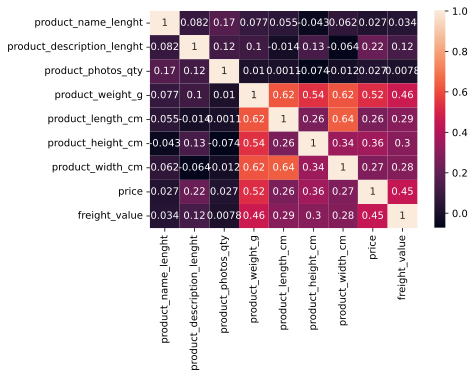

In [67]:
sns.heatmap(products_w_price.loc[:,(products_w_price.dtypes == float).values].corr(method='spearman'), annot=True)

ok this is basically the same as in the exploration but with colors, these colors however give us a good way to group correlations, we can see that the width, height, length and weight create a nice block, and are also correlated with the price.

#### Variance Inflation

We looked into the inflation inbetween those correlated columns, because it might be that they are telling the same story. To illustrate this information we can use a bar chart.

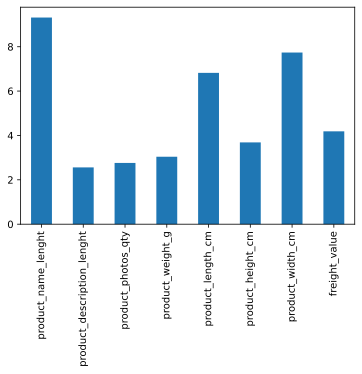

In [68]:
pd.Series(vif_price).plot.bar()

This way we can see that both the product length and width are highly correlated with other columns in the dataset i.e. their variation is explainable by other columns in the dataset. We opted to not remove any parameters here.

#### Categorical correlation

We performed anova tests to know if and how much variance there is between categories for each numerical column. we can use a bar plot to visualize.

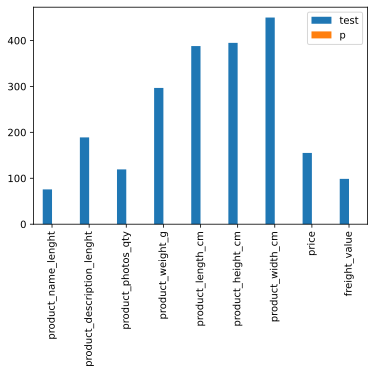

In [69]:
anova_price.plot.bar()

This might not be my best plot I ever made, but it quantifies the amount of variation of a numerical column compared to the category column 'category' item specs as size vary more whilst the name and description remain much more the same. In this plot, you can see I made a crucial mistake by using the same axis range for the test statistic and the p-value, which is much smaller (between 0-1). Don't do this yourself! (I didn't bother as all p-values are 0 except for order_item_id)

#### Grouping by category

As last we grouped by category and recalculated the numerical correlation for each category apart. Note that we removed lowly populated categories as the prediction of the price might be not representative. I will use a boxplot to show any variation

In [70]:
products_w_price_sorted_price = products_w_price.groupby('product_category_name').median().sort_values('price').index
products_w_price_sorted_price

CategoricalIndex(['home_comfort_2', 'dvds_blu_ray', 'electronics', 'flowers',
                  'telephony', 'portateis_cozinha_e_preparadores_de_alimentos',
                  'diapers_and_hygiene', 'fixed_telephony', 'food_drink',
                  'books_general_interest', 'drinks', 'home_appliances',
                  'fashion_bags_accessories', 'arts_and_craftmanship',
                  'fashio_female_clothing', 'cds_dvds_musicals', 'food',
                  'books_technical', 'christmas_supplies',
                  'costruction_tools_garden', 'fashion_underwear_beach',
                  'fashion_male_clothing', 'garden_tools', 'fashion_sport',
                  'books_imported', 'music', 'housewares', 'market_place',
                  'consoles_games', 'party_supplies', 'furniture_decor',
                  'costruction_tools_tools', 'stationery', 'baby',
                  'signaling_and_security', 'computers_accessories',
                  'bed_bath_table', 'auto', 'fashion_shoes'

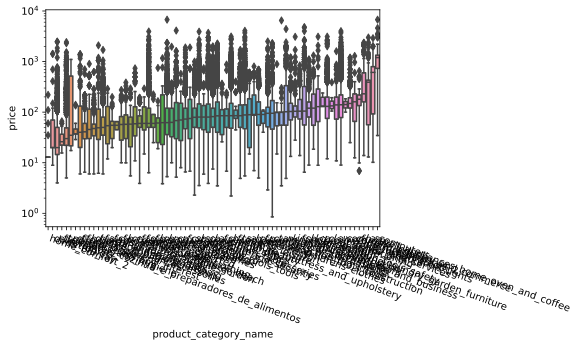

In [71]:
ax = sns.boxplot(data=products_w_price, x='product_category_name', y='price', order=products_w_price_sorted_price)
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(),rotation=-20,horizontalalignment='left');

cool! here we can see the variation in groups for the price column, this way we can deduce wich categories are highly priced and which are lowly priced. Our machine learning solution later will use this information to help decide the price (if we of course use it to train the model). We can conclude that while the variation in each category can be high, there is a trend in price between categories.

We also calculated relative changes of correlation between price and other numerical columns inbetween categories. Let's see if we can visualize that information, my best guess would be a bar chart

In [72]:
pricing_most_important.head()

,parameter,relative_correlation
product_category_name,,
small_appliances_home_oven_and_coffee,product_photos_qty,0.705878
computers,product_photos_qty,0.703822
furniture_bedroom,product_photos_qty,0.638002
home_confort,product_name_lenght,0.631313
fashion_shoes,product_name_lenght,0.604471


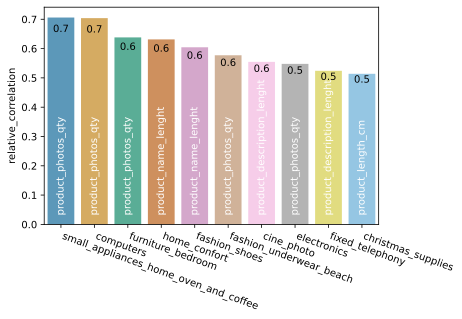

In [73]:
top_n = 10
ax = sns.barplot(x=pricing_most_important.head(top_n).index.to_list(), y=pricing_most_important.head(top_n)['relative_correlation'], alpha=0.7, palette='colorblind')
for idx, p in enumerate(ax.patches):
    ax.annotate(pricing_most_important.head(top_n)['parameter'][idx], 
                   (p.get_x() + p.get_width() / 2., 0), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 9), 
                rotation = 90,
                  color='white',
                   textcoords = 'offset points')
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()*0.9), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax.set_xticklabels(ax.get_xticklabels(),rotation=-20,horizontalalignment='left');

You can see I put a little bit more effort in this last graph as I think this is the nice visualisation to show others. We can also make a similar plot but with the relatively least important features.

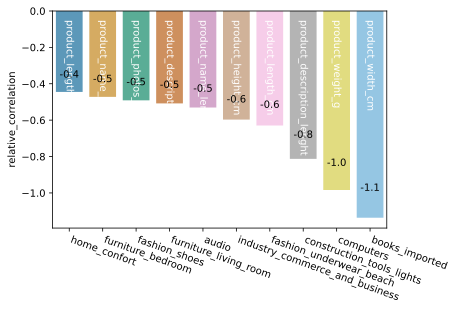

In [74]:
top_n = 10
ax = sns.barplot(x=pricing_least_important.tail(top_n).index.to_list(), y=pricing_least_important.tail(top_n)['relative_correlation'], alpha=0.7, palette='colorblind')
for idx, p in enumerate(ax.patches):
    ax.annotate(pricing_least_important.tail(top_n)['parameter'][idx], 
                   (p.get_x() + p.get_width() / 2., 0), 
                   ha = 'center', va = 'top', 
                   xytext = (0, -9), 
                rotation = -90,
                  color='white',
                   textcoords = 'offset points')
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()*0.9), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax.set_xticklabels(ax.get_xticklabels(),rotation=-20,horizontalalignment='left');

## Summary

### Product pricing

To conclude the product pricing analysis, we checked for normal distributions which werent present, so we had to opt for non-parametric/non-linear methods (although in many cases these will still do fine). We checked for numerical correlations but these were not really interesting, which led to the idea that perhaps per category our price could be predicted more accurate. This was proven by the fact that our price surely differs inbetween categories. 

We split up our dataset by grouping per category and removing small categories, now we could see that a relative change in correlation - meaning that the correlation of a column in our dataset with the price was different in that category compared to the overall correlation of this column with the price - was present for all categories. For each category we selected both the highest increase in correlation - meaning a 'spike' in importance - for that category and the highest decrease - meaning a 'drop' in importance - for that category.

These plots hence show the most important and least important attributes for an item concerning the price e.g. if we want to increase the price of an item in the computers category, we need to make sure it has enough pictures and not try to decrease the weight value.